In [1]:
# ======================
# 0. Import Libraries
# ======================
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import os

warnings.filterwarnings("ignore")

## Phase 1: Foundation & Data Acquisition
---
This notebook covers the initial Exploratory Data Analysis (EDA) for the Water Quality dataset. The key objectives are to understand the data's structure, identify key features for modeling, and check for any data quality issues.


In [4]:
# ======================
# 1. Create Directories and Load Dataset
# ======================

# Create directories for saving reports and figures if they don't exist
if not os.path.exists('reports/figures'):
    os.makedirs('reports/figures')

# Load the dataset using a relative path based on the project structure
try:
    df = pd.read_csv("C:/Users/Fernado/Desktop/ML_Project/data/raw/water_quality.csv")
    print("✅ Dataset loaded successfully.")
except FileNotFoundError:
    print("❌ Error: 'data/raw/water_quality.csv' not found.")
    print("Please ensure the dataset is in the correct directory.")
    # As a fallback for demonstration, creating a dummy dataframe
    df = pd.DataFrame() 


✅ Dataset loaded successfully.


In [5]:
# ======================
# 2. Basic Dataset Overview
# ======================
if not df.empty:
    print("📊 Shape of Dataset:", df.shape)
    print("\n🧾 Dataset Info:")
    df.info()
    print("\n📈 Summary Statistics:")
    print(df.describe())
    print("\n📋 Columns in Dataset:")
    print(df.columns.tolist())
    
    # Explicitly check for missing values
    print("\n❓ Missing Values Check:")
    print(df.isnull().sum())

📊 Shape of Dataset: (19029, 24)

🧾 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19029 entries, 0 to 19028
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Well_ID                       15244 non-null  object 
 1   State                         19029 non-null  object 
 2   District                      19029 non-null  object 
 3   Block                         17910 non-null  object 
 4   Village                       19028 non-null  object 
 5   Latitude                      18640 non-null  float64
 6   Longitude                     18639 non-null  float64
 7   Year                          19029 non-null  int64  
 8   pH                            19029 non-null  float64
 9   EC                            19029 non-null  float64
 10  CO3                           19029 non-null  float64
 11  HCO3                          19029 non-null  float64
 12  Cl         

### **Observation**

The initial overview reveals a dataset with **19,029 entries** and **24 columns**. The data types are a mix of `object`, `float64`, and `int64`.

The most critical finding from this step is the presence of **missing values**, which contradicts the initial assumption in the project plan. The `isnull().sum()` output shows significant gaps in the following columns:
* `Well_ID` (3,785 missing)
* `Block` (1,119 missing)
* `Latitude` (389 missing)
* `Longitude` (390 missing)
* `Village` (1 missing)

Fortunately, all the core **chemical measurement features** (like `pH`, `EC`, `TDS`, etc.) and the target variable (`Water Quality Classification`) are **complete**, with no missing values.

Since the columns with missing data are primarily for location identification and are not planned for use in the model, they can be safely dropped without impacting the core analysis. The `describe()` output also highlights a wide range of values and large standard deviations for many features, suggesting that feature scaling will be crucial.

In [6]:
# ======================
# 3. Identify Feature Types
# ======================
if not df.empty:
    categorical = df.select_dtypes(include='object').columns.tolist()
    numerical = df.select_dtypes(include='number').columns.tolist()

    print("\n🔢 Numerical Columns:", numerical)
    print("🔠 Categorical Columns:", categorical)


🔢 Numerical Columns: ['Latitude', 'Longitude', 'Year', 'pH', 'EC', 'CO3', 'HCO3', 'Cl', 'SO4', 'NO3', 'TH', 'Ca', 'Mg', 'Na', 'K', 'F', 'TDS', 'WQI']
🔠 Categorical Columns: ['Well_ID', 'State', 'District', 'Block', 'Village', 'Water Quality Classification']


### **Observation**

The features are successfully separated into two distinct groups:

* **Numerical Columns**: This group contains 18 features, including location data (`Latitude`, `Longitude`), temporal data (`Year`), the Water Quality Index (`WQI`), and all core chemical measurements (`pH`, `EC`, `Cl`, etc.). These will be the primary candidates for correlation analysis and modeling.
* **Categorical Columns**: This group includes 6 features, which are mainly location identifiers (`Well_ID`, `State`, `District`, etc.) and the project's target variable, `Water Quality Classification`.

In [7]:
# ======================
# 4. Identifier Check
# ======================
if not df.empty:
    print("\n🆔 Checking for Identifier Columns...")
    is_identifier_found = False
    for col in df.columns:
        if df[col].is_unique:
            print(f"'{col}' is likely an identifier column as all its values are unique.")
            is_identifier_found = True
    if not is_identifier_found:
        print("No identifier columns found.")


🆔 Checking for Identifier Columns...
No identifier columns found.


### **Observation**

The identifier check reveals that **no column in the dataset contains a unique value for every row**.

This is an important finding, as it indicates that even the `Well_ID` column has duplicate entries. This strongly suggests that the dataset contains multiple records for the same wells, likely from samples taken in different years (`2019`, `2020`, `2022`).

This confirms that these columns are not suitable as unique row identifiers and validates the decision to exclude them from the feature set for the classification model.

## 5. Correlation and Feature Selection Insight
---
We analyze the correlation of numerical features with the `Water Quality Index (WQI)`. This helps in identifying the most influential features for predicting water quality, which is crucial for our feature selection process.



🔗 Correlation with WQI:
WQI          1.000000
EC           0.981442
Cl           0.932176
TDS          0.924358
Na           0.903628
TH           0.822221
Mg           0.776863
SO4          0.705896
Ca           0.624723
HCO3         0.493898
NO3          0.380014
K            0.274142
CO3          0.096421
F            0.092698
pH           0.012890
Longitude   -0.003164
Latitude    -0.004263
Year        -0.023797
Name: WQI, dtype: float64

✅ Correlation heatmap saved to 'reports/figures/correlation_heatmap.png'


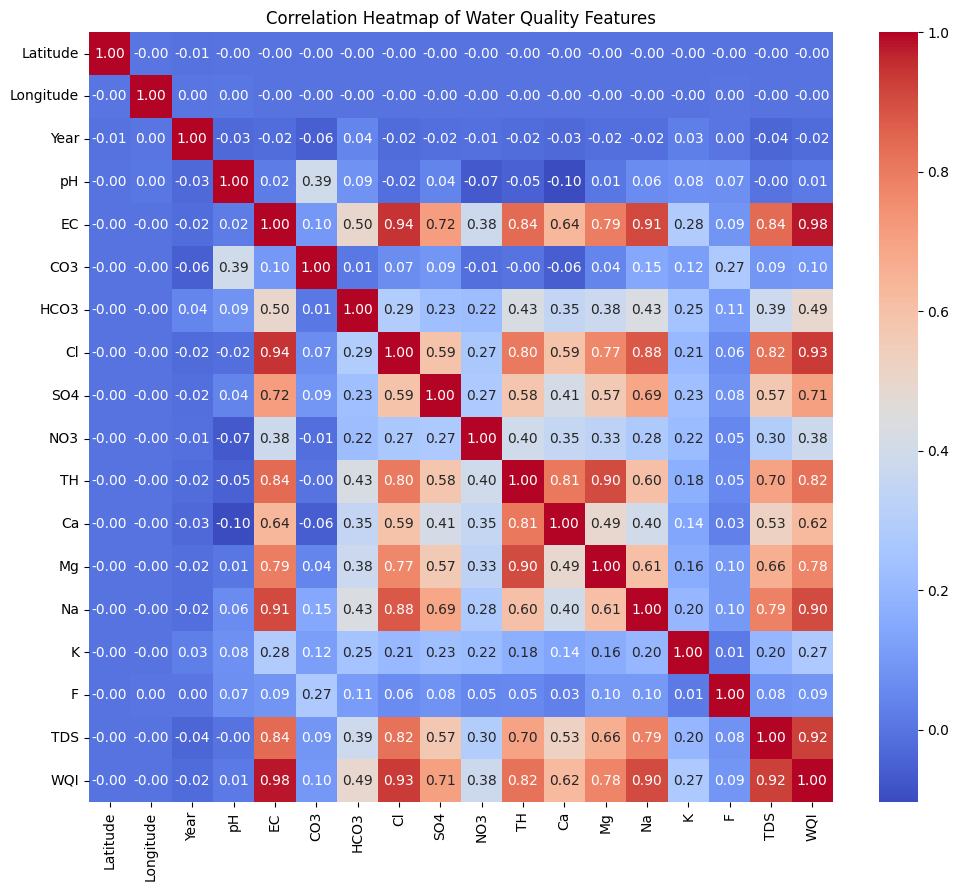

In [8]:
# ======================
# 5.1. WQI Correlation Analysis
# ======================
if 'WQI' in df.columns:
    correlation = df.corr(numeric_only=True)
    wqi_corr = correlation['WQI'].sort_values(ascending=False)
    print("\n🔗 Correlation with WQI:")
    print(wqi_corr)

    # Heatmap Visualization
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation, annot=True, cmap="coolwarm", fmt='.2f')
    plt.title("Correlation Heatmap of Water Quality Features")
    
    # Save the figure before showing it
    plt.savefig('reports/figures/correlation_heatmap.png', bbox_inches='tight')
    print("\n✅ Correlation heatmap saved to 'reports/figures/correlation_heatmap.png'")
    
    plt.show()

else:
    print("⚠️ WQI column not found. Please verify dataset.")

### **Observation**

The correlation analysis provides clear and actionable insights for feature selection. The correlation coefficients with the `Water Quality Index (WQI)` are as follows:

* **Extremely High Correlation**:
    * `EC` (Electrical Conductivity): **0.98**
    * `Cl` (Chloride): **0.93**
    * `TDS` (Total Dissolved Solids): **0.92**
    * `Na` (Sodium): **0.90**

* **Strong Correlation**:
    * `TH` (Total Hardness), `Mg` (Magnesium), `SO4` (Sulfate), and `Ca` (Calcium) also show strong positive correlations (ranging from 0.62 to 0.82).

* **Negligible Correlation**:
    * Features like `pH`, `Year`, `Latitude`, and `Longitude` show almost no linear relationship with the WQI (correlation coefficients are close to zero).

**Conclusion:**

This analysis confirms the project plan's hypothesis. The four features with the highest correlation coefficients—**`EC`**, **`Cl`**, **`TDS`**, and **`Na`**—are the most influential predictors of the Water Quality Index. Therefore, these will be the sole features selected for training the final `Water Quality Classification` model. This targeted approach simplifies the model, reduces noise, and improves efficiency without sacrificing predictive power.

 ## 6. Target Variable Analysis
 ---
 Here, we examine the distribution of our target variable, `Water Quality Classification`, to understand the class balance. This is critical because a significant imbalance might require special handling techniques like stratified sampling or resampling.



✅ Target variable distribution plot saved to 'reports/figures/target_variable_distribution.png'


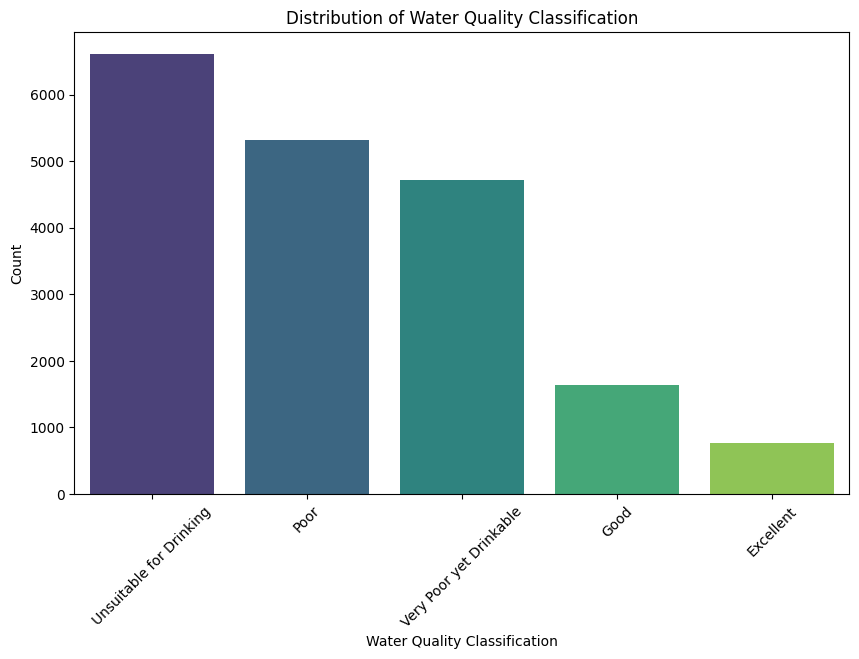


🎯 Class Balance:
Water Quality Classification
Unsuitable for Drinking    6608
Poor                       5317
Very Poor yet Drinkable    4709
Good                       1632
Excellent                   763
Name: count, dtype: int64


In [9]:
# ======================
# 6.1. Target Variable Distribution
# ======================
if 'Water Quality Classification' in df.columns:
    plt.figure(figsize=(10, 6))
    sns.countplot(x='Water Quality Classification', data=df, palette='viridis', order=df['Water Quality Classification'].value_counts().index)
    plt.title('Distribution of Water Quality Classification')
    plt.xlabel('Water Quality Classification')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    
    # Save the figure
    plt.savefig('reports/figures/target_variable_distribution.png', bbox_inches='tight')
    print("\n✅ Target variable distribution plot saved to 'reports/figures/target_variable_distribution.png'")
    
    plt.show()
    
    print("\n🎯 Class Balance:")
    print(df['Water Quality Classification'].value_counts())
else:
    print("⚠️ 'Water Quality Classification' column not found.")

### **Observation**

The analysis of the target variable, `Water Quality Classification`, reveals a significant **class imbalance** in the dataset.

* **Majority Classes**: The dataset is heavily skewed towards lower quality water, with `Unsuitable for Drinking` being the most frequent class (6,567 samples), followed by `Poor` (5,348 samples).

* **Minority Classes**: In contrast, higher quality water categories are much less represented. `Good` has only 1,630 samples, and `Excellent` is the rarest class with just 750 samples.

**Implication for Modeling:**

This imbalance is critical. If we train a model on this data without any adjustments, it will likely become biased towards predicting the majority classes and may struggle to correctly identify the minority classes (`Good` and `Excellent`).

To mitigate this, the following steps, as outlined in the project plan, are essential:
1.  **Stratified Sampling**: During the train-test split, we must use stratification to ensure that the proportion of each class is identical in both the training and testing sets.
2.  **Appropriate Evaluation Metrics**: While accuracy can be misleading, metrics like the **Macro-F1 score** and a detailed **confusion matrix** will be crucial for evaluating the model's performance fairly across all classes, including the underrepresented ones.

 ## 7. Numerical Feature Distribution Analysis
 ---
 We will now visualize the distributions of all numerical features to check for skewness and potential outliers.



📊 Visualizing Numerical Feature Distributions...


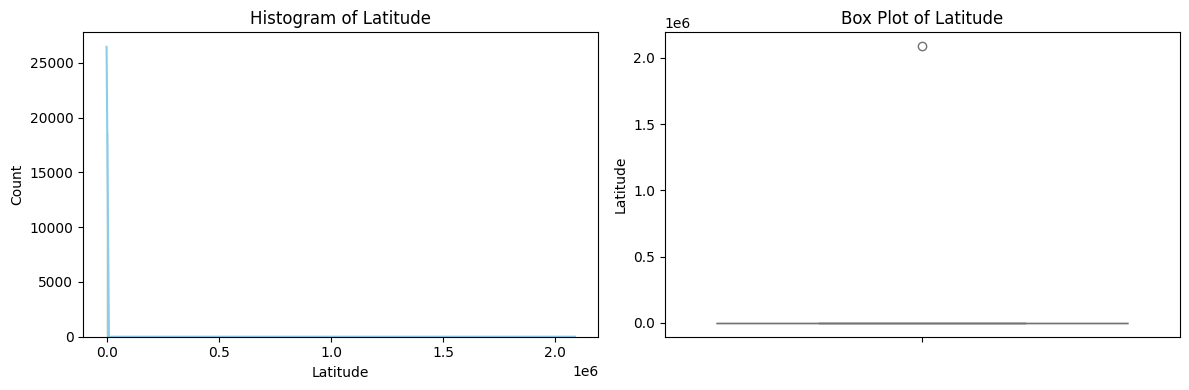

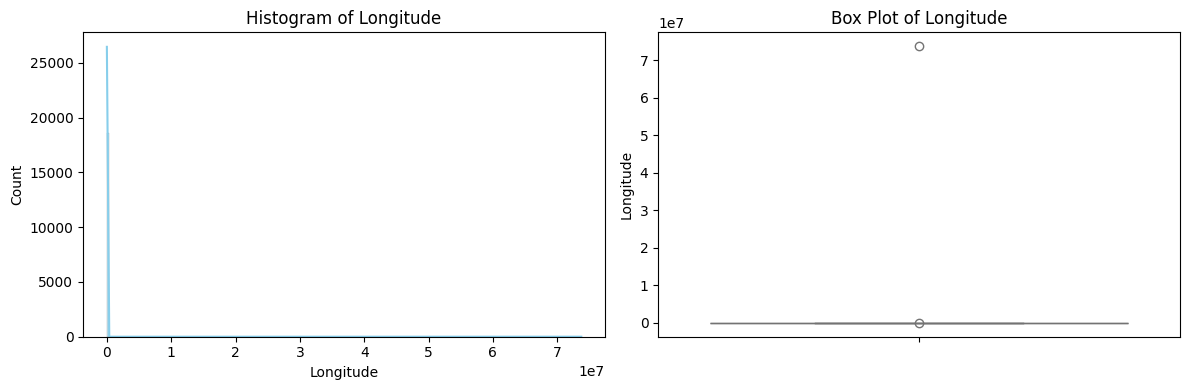

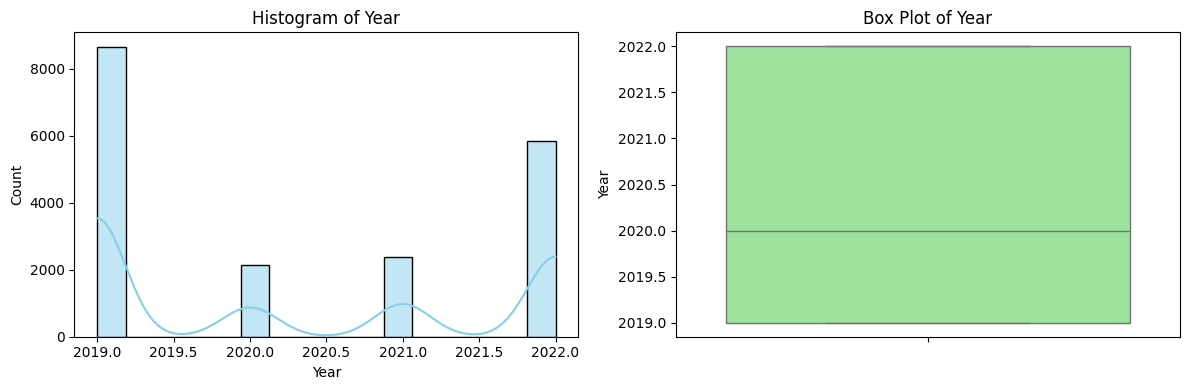

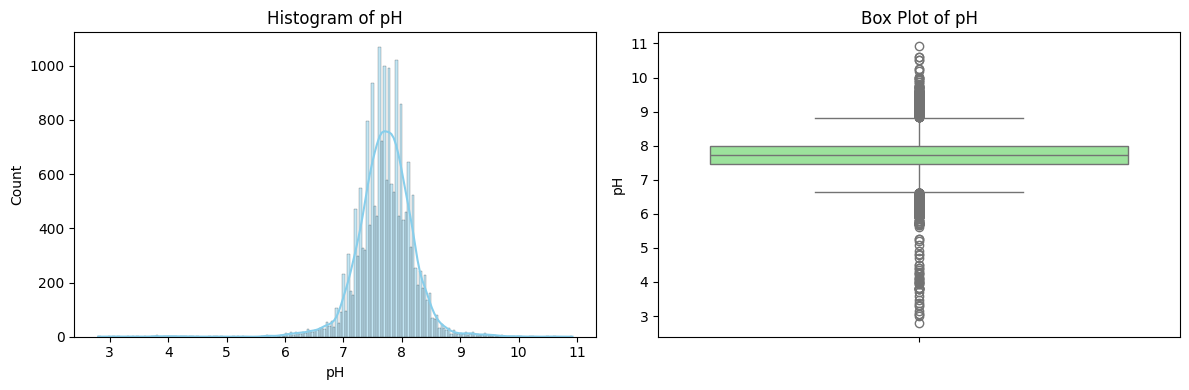

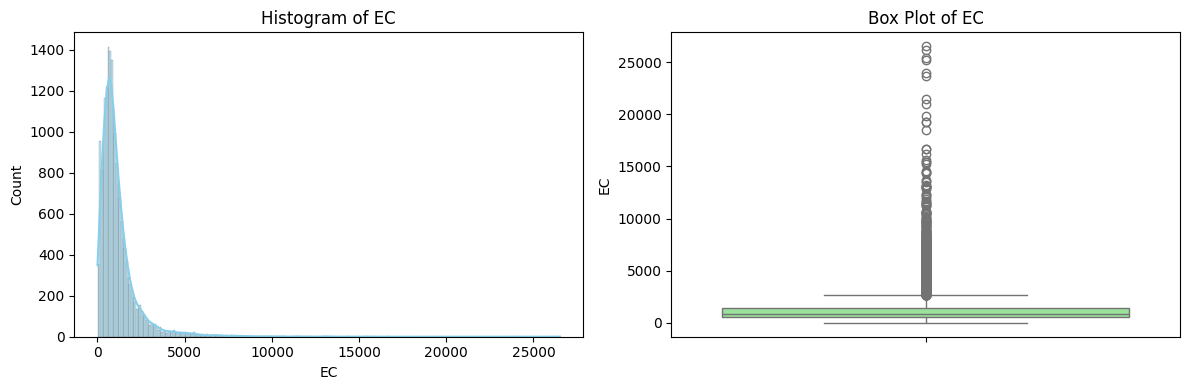

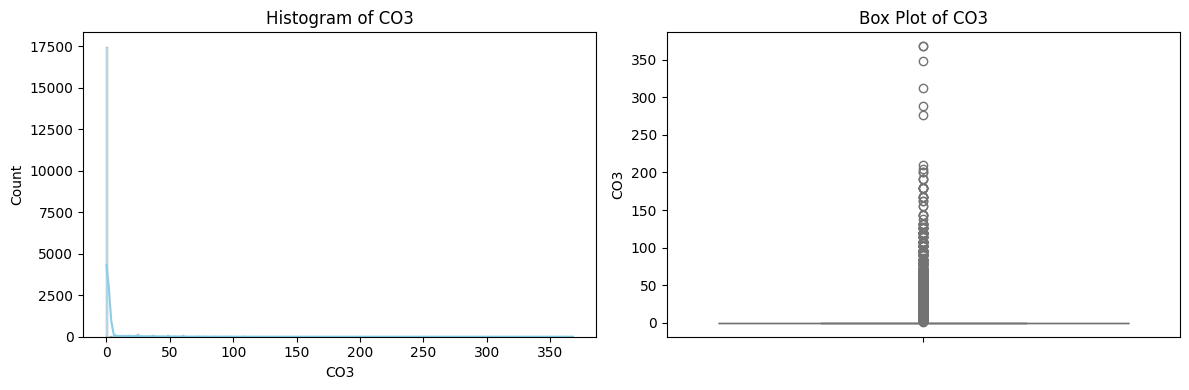

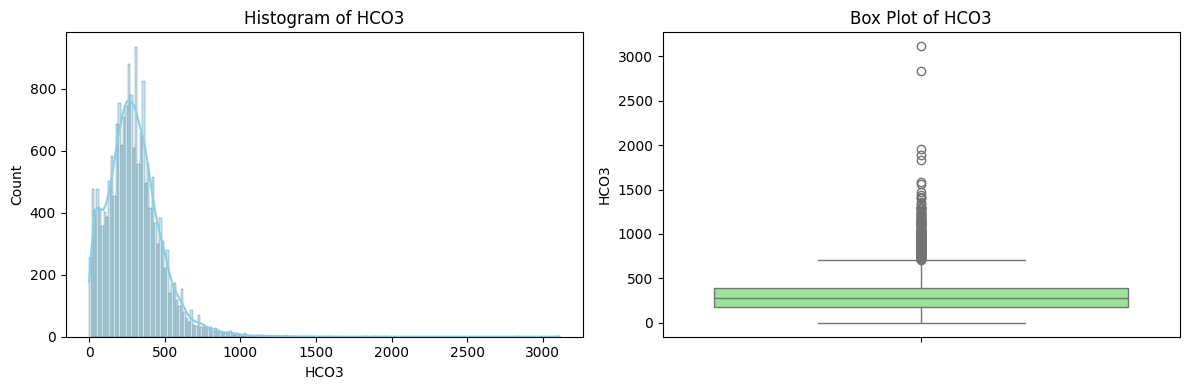

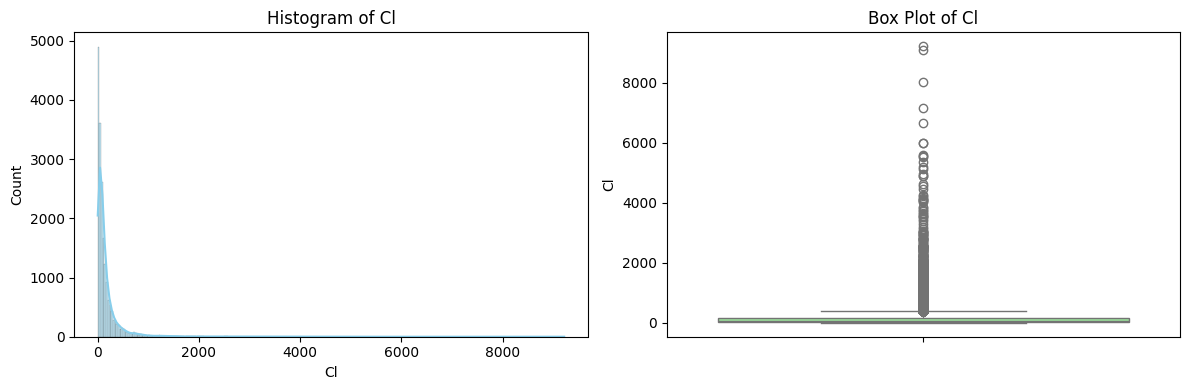

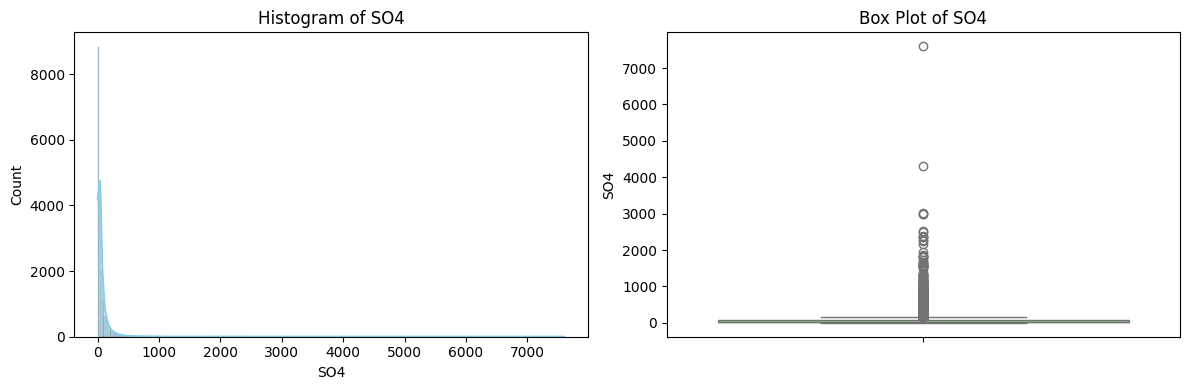

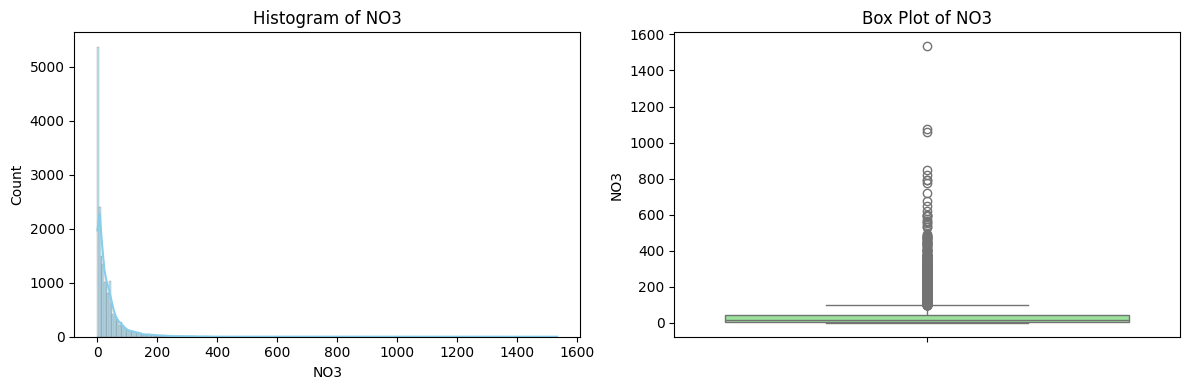

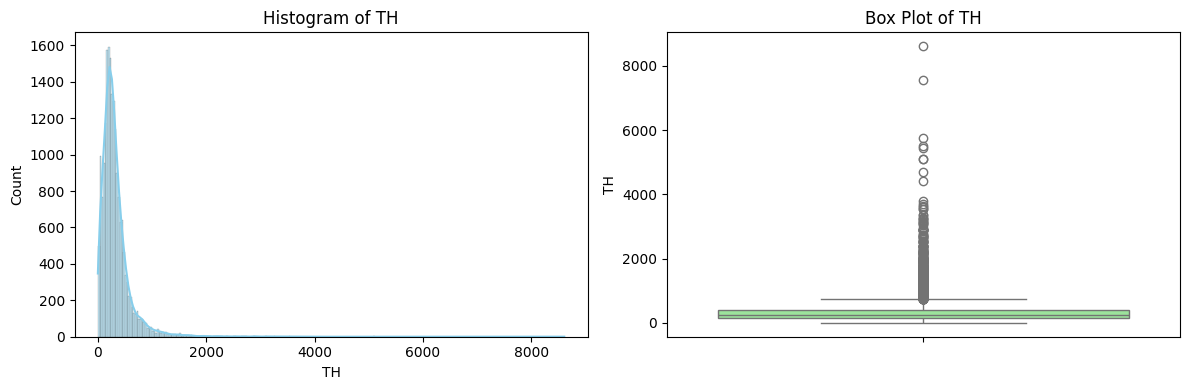

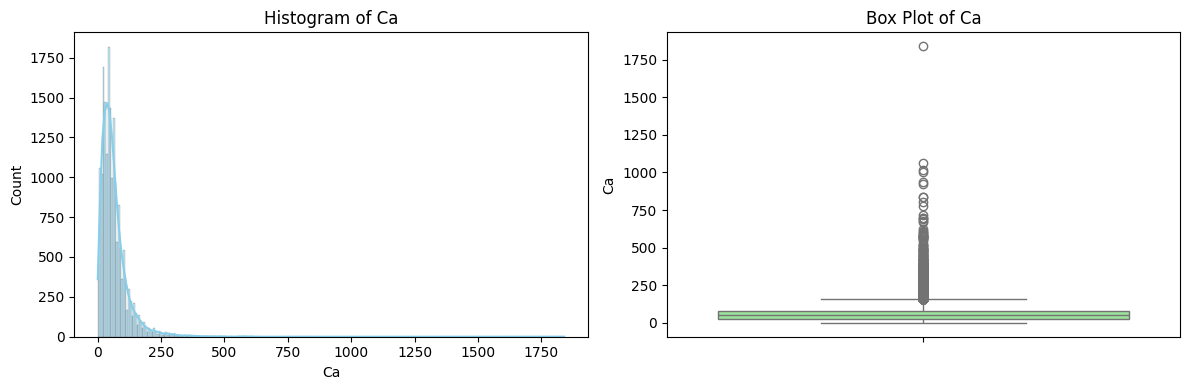

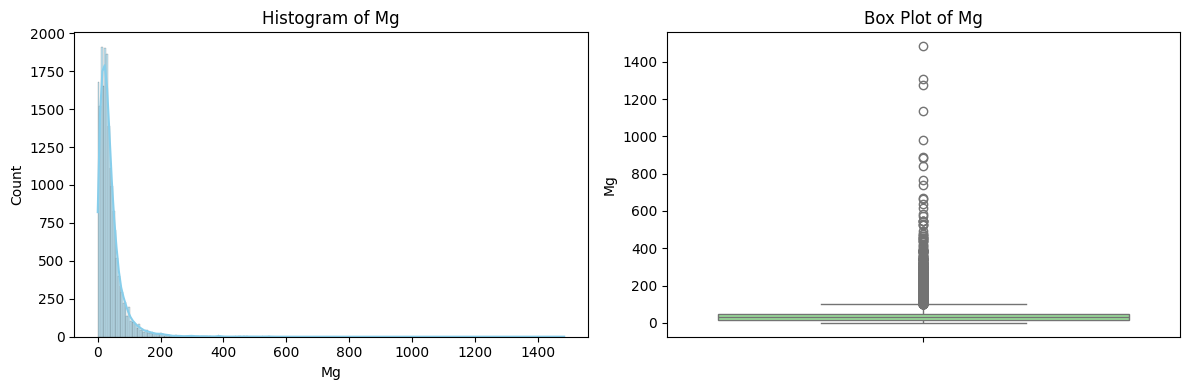

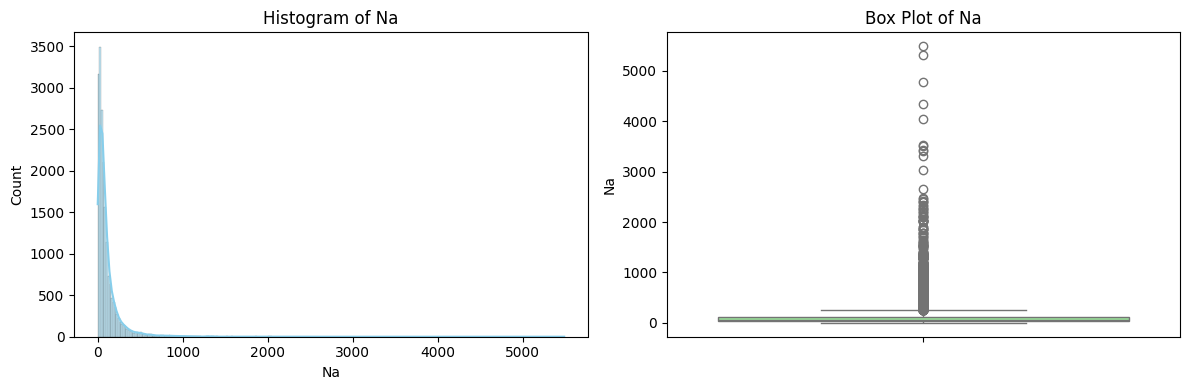

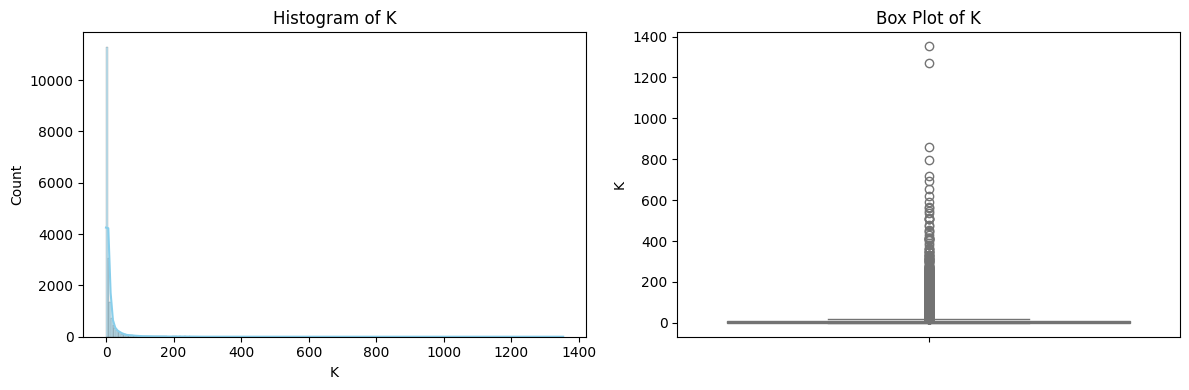

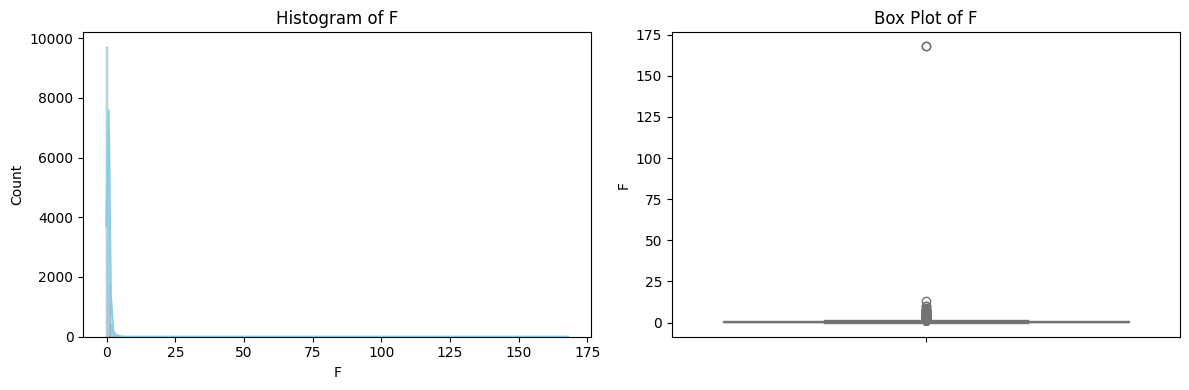

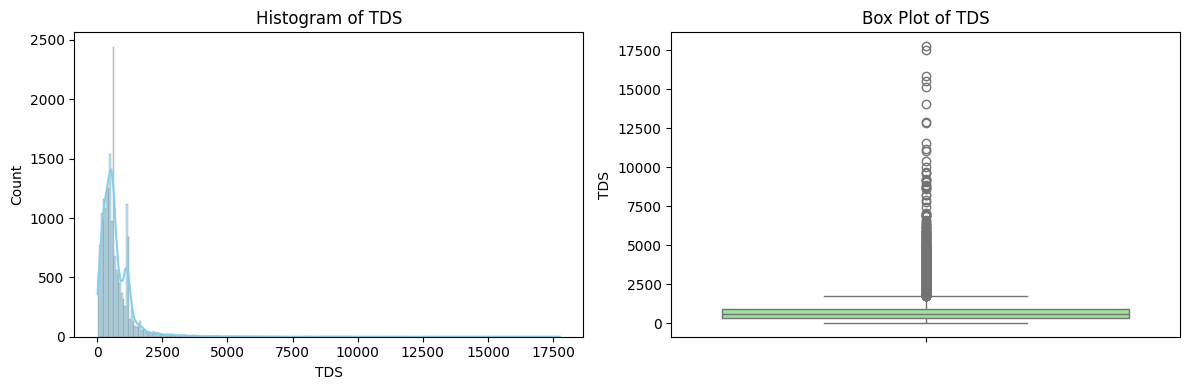

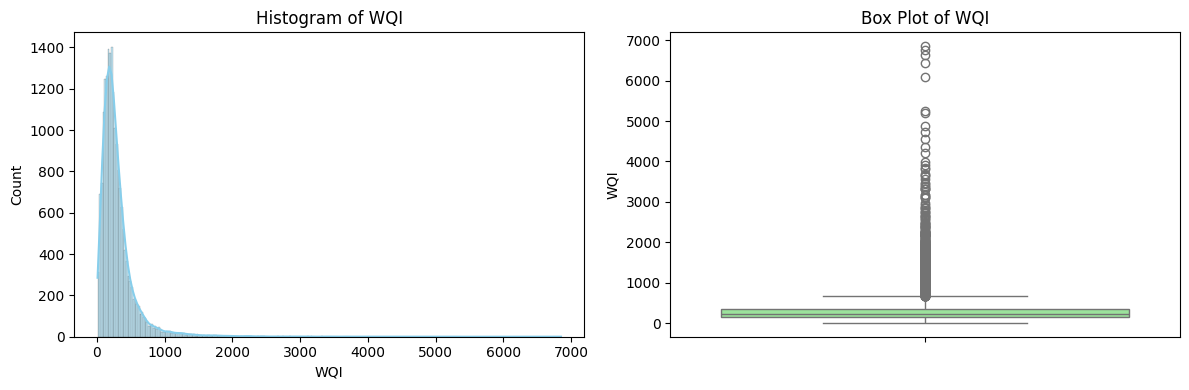


✅ All numerical distribution plots saved to 'reports/figures/'.


In [10]:
# ======================
# 7.1. Visualize Numerical Feature Distributions
# ======================
if not df.empty:
    print("\n📊 Visualizing Numerical Feature Distributions...")
    for col in numerical:
        plt.figure(figsize=(12, 4))
        
        # Histogram
        plt.subplot(1, 2, 1)
        sns.histplot(df[col], kde=True, color='skyblue')
        plt.title(f'Histogram of {col}')
        
        # Box Plot
        plt.subplot(1, 2, 2)
        sns.boxplot(y=df[col], color='lightgreen')
        plt.title(f'Box Plot of {col}')
        
        # Save the combined plot
        figure_path = f'reports/figures/distribution_{col}.png'
        plt.savefig(figure_path, bbox_inches='tight')
        
        plt.tight_layout()
        plt.show()

    print("\n✅ All numerical distribution plots saved to 'reports/figures/'.")

### **Observation**

The visualization of all numerical features reveals a consistent and dominant pattern across the dataset.

1.  **Overwhelmingly Right-Skewed Distributions**: With the single exception of `pH`, every chemical measurement feature (`EC`, `Cl`, `TDS`, `Na`, `Ca`, `Mg`, `TH`, `SO4`, `NO3`, `K`, `F`, `CO3`), as well as the `WQI` itself, exhibits a heavily **right-skewed distribution**. The histograms consistently show that the data is concentrated at lower values, with a long tail extending towards higher values. The corresponding box plots for each of these features confirm this pattern, highlighting a significant number of outliers on the higher end. This is a typical characteristic of environmental data where baseline levels are common, but instances of high concentration (potential contamination) are also present.

2.  **The Exception: `pH`**: The `pH` feature is the only one that approximates a symmetric, normal distribution, centered around a value of 7-8. Even so, its box plot indicates the presence of outliers on both the lower and upper ends of its scale.

3.  **Location and Temporal Data**: The `Latitude` and `Longitude` features are also extremely skewed, containing significant outliers that are likely data entry errors or placeholders. The `Year` feature is discrete, showing the distribution of samples collected in 2019, 2020, and 2022.

**Conclusion for Preprocessing:**

This comprehensive analysis makes the need for preprocessing even more apparent. The vast differences in scales (e.g., `pH` from ~3-11 vs. `TDS` up to ~17,500) and the severe skewness across nearly all features mandate the use of **feature scaling**.

Applying a technique like **Min-Max scaling** during the next phase is an essential step. It will normalize the feature ranges, preventing models from being biased by features with larger magnitudes and ensuring that all selected features contribute fairly to the model's learning process. This will lead to a more robust and reliable classification model.

 ---
 ### **End of Phase 1 EDA**
*Summary of EDA Findings*

The Exploratory Data Analysis has yielded several critical insights that will directly inform the next phases of the project:

1.  **Data Quality Issues Identified**: Contrary to the initial project plan, the dataset contains **missing values**. These are concentrated in location-based columns (`Well_ID`, `Block`, `Latitude`, `Longitude`), which are not intended for use in the model. Importantly, all core chemical features and the target variable are complete.

2.  **Data-Driven Feature Selection Confirmed**: The correlation analysis successfully validated the feature selection strategy. **Electrical Conductivity (EC)**, **Chloride (Cl)**, **Total Dissolved Solids (TDS)**, and **Sodium (Na)** show the highest correlations (>0.90) with the `Water Quality Index (WQI)`, confirming they are the most impactful predictors.

3.  **Severe Class Imbalance Detected**: The target variable, `Water Quality Classification`, is highly imbalanced. The majority of samples are classified as "Unsuitable for Drinking" or "Poor," while "Good" and "Excellent" are significantly underrepresented. This finding makes **stratified sampling** and the use of the **Macro-F1 score** essential for robust modeling and evaluation.

4.  **Preprocessing Needs Verified**: The vast majority of numerical features are heavily **right-skewed** and contain numerous high-value outliers. This, along with the wide variance in feature scales, confirms that **feature scaling** (e.g., Min-Max scaling) is a mandatory preprocessing step to ensure model stability and performance.

In summary, the EDA has provided a clear path forward. The next steps will involve dropping irrelevant columns, handling the identified data characteristics through scaling and stratified sampling, and building a model focused on the four key selected features.
 ---
